In [66]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


df=pd.read_csv("FormattedData/train.csv",parse_dates=["Timestamp"],index_col=[0])
df.head()

,MON1 CL DDM (?A),MON1 CL RF (dB),MON1 DS DDM (?A),MON1 DS RF (dB),MON1 NF DDM (?A),MON1 NF RF (dB),MON1 CLR DDM (?A),MON1 CLR RF (dB)
Timestamp,,,,,,,,
2022-02-09 09:42:12,3.76,0.31,2.31,0.26,-2.89,0.17,6.07,0.30
2022-02-09 09:47:12,3.18,0.31,2.31,0.26,-2.31,0.14,6.94,0.28
2022-02-09 09:52:13,3.47,0.31,2.02,0.26,-2.60,0.13,7.23,0.28
2022-02-09 09:57:13,3.47,0.30,2.02,0.25,-2.02,0.14,6.94,0.28
2022-02-09 10:02:13,3.47,0.30,2.02,0.25,-2.02,0.10,7.23,0.28


In [67]:
test_split=round(len(df)*0.20)
df_for_training=df[:-1041]
df_for_testing=df[-1041:]
print(df_for_training.shape)
print(df_for_testing.shape)

(11076, 8)
(1041, 8)


In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.77237049, 0.99500595, 0.9891791 , ..., 0.98042574, 0.98783418,
        0.99566748],
       [0.68131868, 0.99500595, 0.9891791 , ..., 0.97969171, 0.99044758,
        0.99512591],
       [0.72684458, 0.99500595, 0.98557214, ..., 0.97944703, 0.99131871,
        0.99512591],
       ...,
       [0.45525903, 0.99595719, 0.97126866, ..., 0.97846831, 0.97828177,
        0.99702139],
       [0.45525903, 0.99595719, 0.97126866, ..., 0.97846831, 0.97828177,
        0.99729217],
       [0.45525903, 0.99595719, 0.97126866, ..., 0.97846831, 0.97828177,
        0.99729217]])

In [69]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [70]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)


print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (11046, 30, 8)
trainY Shape--  (11046,)
testX Shape--  (1011, 30, 8)
testY Shape--  (1011,)


In [71]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.77237049 0.99500595 0.9891791  0.9950446  0.80802213 0.98042574
  0.98783418 0.99566748]
 [0.68131868 0.99500595 0.9891791  0.9950446  0.82406639 0.97969171
  0.99044758 0.99512591]
 [0.72684458 0.99500595 0.98557214 0.9950446  0.81604426 0.97944703
  0.99131871 0.99512591]
 [0.72684458 0.99476813 0.98557214 0.99479683 0.83208852 0.97969171
  0.99044758 0.99512591]
 [0.72684458 0.99476813 0.98557214 0.99479683 0.83208852 0.97871299
  0.99131871 0.99512591]
 [0.77237049 0.99453032 0.9891791  0.99479683 0.83983402 0.97895767
  0.99131871 0.99512591]
 [0.77237049 0.99453032 0.98557214 0.99454906 0.85587828 0.97822364
  0.99131871 0.99512591]
 [0.77237049 0.9940547  0.9891791  0.99405352 0.84785615 0.97895767
  0.99306098 0.99458435]
 [0.77237049 0.99381688 0.99278607 0.99355798 0.83983402 0.98042574
  0.99393211 0.99431357]
 [0.77237049 0.99381688 0.99278607 0.99355798 0.83208852 0.9809151
  0.99393211 0.99431357]
 [0.77237049 0.99381688 0.99278607 0.99355798 0.82406639 

In [74]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,8)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer, metrics=['accuracy'])
    return grid_model

optimizer = ['Adam']
epochs = [10]

param_grid = dict(epochs=epochs, optimizer=optimizer)

Kmodel = KerasClassifier(build_fn=build_model, verbose=1)
grid = GridSearchCV(estimator=Kmodel, param_grid=param_grid, n_jobs=None, refit='boolean')





/tmp/ipykernel_387/3531685089.py:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  Kmodel = KerasClassifier(build_fn=build_model, verbose=1)


In [75]:
grid_result = grid.fit(trainX, trainY)

Epoch 1/10
277/277 [==============================] - 6s 16ms/step - loss: 12.0111 - accuracy: 6.7904e-04
Epoch 2/10
277/277 [==============================] - 4s 16ms/step - loss: 4.4032 - accuracy: 6.7904e-04
Epoch 3/10
277/277 [==============================] - 5s 17ms/step - loss: 2.4441 - accuracy: 6.7904e-04
Epoch 4/10
277/277 [==============================] - 5s 17ms/step - loss: 1.9059 - accuracy: 6.7904e-04
Epoch 5/10
277/277 [==============================] - 4s 16ms/step - loss: 1.6866 - accuracy: 6.7904e-04
Epoch 6/10
277/277 [==============================] - 5s 18ms/step - loss: 1.5797 - accuracy: 6.7904e-04
Epoch 7/10
277/277 [==============================] - 5s 17ms/step - loss: 1.5141 - accuracy: 6.7904e-04
Epoch 8/10
277/277 [==============================] - 5s 18ms/step - loss: 1.5153 - accuracy: 6.7904e-04
Epoch 9/10
277/277 [==============================] - 5s 17ms/step - loss: 1.4163 - accuracy: 6.7904e-04
Epoch 10/10
70/70 [==============================] - 1

In [76]:
grid.best_params_



{'epochs': 10, 'optimizer': 'Adam'}

In [33]:
my_model=grid.best_estimator_.model

In [45]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[20.062645]
 [20.06235 ]
 [20.06245 ]
 ...
 [20.062996]
 [20.06296 ]
 [20.062962]]

Prediction Shape- (1011, 1)


In [54]:
scaler.inverse_transform(prediction)

ValueError: non-broadcastable output operand with shape (1011,1) doesn't match the broadcast shape (1011,8)

In [49]:
prediction_copies_array = np.repeat(prediction,8, axis=-1)

In [50]:
prediction_copies_array.shape

(1011, 8)

In [51]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),8)))[:,0]

In [52]:
original_copies_array = np.repeat(testY,8, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),8)))[:,0]

In [53]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [14.018631 14.018395 14.018476 ... 14.01891  14.018882 14.018883]

Original Values--  [2.02 2.02 1.74 ... 1.74 1.74 1.74]


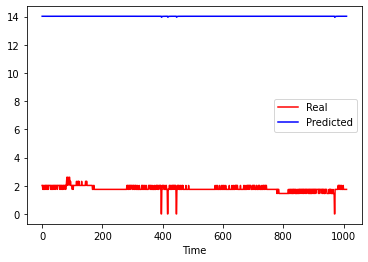

In [80]:
plt.plot(original, color = 'red', label = 'Real')
plt.plot(pred, color = 'blue', label = 'Predicted')
plt.title('')
plt.xlabel('Time')
plt.ylabel('')
plt.legend()
plt.show()

In [56]:
df_30_days_past=df.iloc[-30:,:]
df_30_days_past.tail()

,MON1 CL DDM (?A),MON1 CL RF (dB),MON1 DS DDM (?A),MON1 DS RF (dB),MON1 NF DDM (?A),MON1 NF RF (dB),MON1 CLR DDM (?A),MON1 CLR RF (dB)
Timestamp,,,,,,,,
2022-03-23 12:10:44,1.74,0.22,1.16,0.20,-1.45,0.00,2.6,0.24
2022-03-23 12:15:44,1.74,0.23,0.87,0.20,-1.45,0.00,2.6,0.25
2022-03-23 12:20:45,1.74,0.23,1.16,0.20,-1.45,0.00,2.6,0.25
2022-03-23 12:25:45,1.74,0.23,1.16,0.20,-1.45,0.00,2.6,0.25
2022-03-23 12:30:45,1.74,0.23,0.87,0.21,-1.45,0.01,2.6,0.25


In [59]:
df_30_days_future=pd.read_csv("FormattedData/train.csv",parse_dates=["Timestamp"],index_col=[0])
df_30_days_future

,MON1 CL DDM (?A),MON1 CL RF (dB),MON1 DS DDM (?A),MON1 DS RF (dB),MON1 NF DDM (?A),MON1 NF RF (dB),MON1 CLR DDM (?A),MON1 CLR RF (dB)
Timestamp,,,,,,,,
2022-02-09 09:42:12,3.76,0.31,2.31,0.26,-2.89,0.17,6.07,0.30
2022-02-09 09:47:12,3.18,0.31,2.31,0.26,-2.31,0.14,6.94,0.28
2022-02-09 09:52:13,3.47,0.31,2.02,0.26,-2.60,0.13,7.23,0.28
2022-02-09 09:57:13,3.47,0.30,2.02,0.25,-2.02,0.14,6.94,0.28
2022-02-09 10:02:13,3.47,0.30,2.02,0.25,-2.02,0.10,7.23,0.28
...,...,...,...,...,...,...,...,...
2022-03-23 12:10:44,1.74,0.22,1.16,0.20,-1.45,0.00,2.60,0.24
2022-03-23 12:15:44,1.74,0.23,0.87,0.20,-1.45,0.00,2.60,0.25
2022-03-23 12:20:45,1.74,0.23,1.16,0.20,-1.45,0.00,2.60,0.25


In [77]:
df_30_days_future["Open"]=0
df_30_days_future=df_30_days_future[["MON1 CL DDM (?A)","MON1 CL RF (dB)","MON1 DS DDM (?A)","MON1 DS RF (dB)","MON1 NF DDM (?A)", "MON1 NF RF (dB)", "MON1 CLR DDM (?A)", "MON1 CLR RF (dB)"]]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

In [78]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(
     full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [79]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,8, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),8)))[:,0]
print(y_pred_future_30_days)

[ 56.187813 114.04729  122.47267  ... 119.786476 119.786804 119.78682 ]
